## Parallel Processing Concepts Group Project
## By Taylor Hartman, Kendra Givens, and Scott Hartsell
## CSCI 4330/6330 w/ Dr. Khem Poudel

## ----------------------------------------------------

In [1]:
# Date/time module
from datetime import datetime

In [2]:
# Importing .csv module to write to file
import csv
from csv import writer
# Lists for variable to be written to the data files
time_list = []
metrics_list = []
# file = open('Parallel_Processing_Conecpts_Serial_Results.csv', 'a')
# time_file = open('Parallel_Processing_Conecpts_Serial_Time','a')
# time_reader = csv.reader(time_file)
# time_writer_obj = writer(time_file)

## Apache Spark Instantiation

In [3]:
# Import to find Spark on PC
import findspark
findspark.init()
findspark.find()

# Importing pyspark and Spark Session
import pyspark
from pyspark.sql import SparkSession

# Import garbage collector for deleting dataframes
import gc

# Creating a sprark session
spark = SparkSession.builder.master("local[1]").appName("ECG").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/28 16:57:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Loading Dataset

In [4]:
# Import data into dataframe
df = spark.read.csv("./ecg.csv", header=False, inferSchema=True)

## Splitting of Data Classifications

In [5]:
# Last column holds classification labels, rename to "label"
df = df.withColumnRenamed(df.columns[-1], "label")

In [6]:
# Creating a new data frame with all '1' classification labels and corresponding data
# this does not affect df
df2 = df.filter(df['label'] == '1')

In [7]:
# Overwriting original dataframe with all '0' classification labels and corresponding data
df = df.filter(df['label'] == '0')

## Classification Ratio Balancing

In [8]:
# Seeded random split to get data with label of 1 as close to the number of data with 0 as possible (2079)
df3, df4 = df2.randomSplit([0.30, 0.70], seed=1000)

In [9]:
# Using the union method to add the dataframe with only 1's in it to the dataframe that has only 0's
df = df.union(df4)

In [10]:
# Deleting unused dataframes
del df2
del df3
del df4

# Using the garbage collector to free the memory
gc.collect()

58

## Vectorization of Spark Data Frame

In [11]:
# Creating a list of all column names that are features (minus the last column which is the label)
features_list = df.columns[:-1]

In [12]:
# Importing the vector assembler module from pyspark
from pyspark.ml.feature import VectorAssembler

# Using the VectorAssembler method to create a DenseVector of features called "feature_vector"
feature_vector_assembler = VectorAssembler(inputCols=features_list,
                                           outputCol="feature_vector")

# Transforming the vector and mounting it to the dataframe
df = feature_vector_assembler.transform(df)

## Normalization of Spark Data Frame

In [13]:
# Standardizing the data
from pyspark.ml.feature import StandardScaler

# Creating a scalar with the input being the feature_vector and output scaled_feature_vector
# We choose the options of using standard deviation and mean to normalize the data
scaler = StandardScaler(inputCol="feature_vector",
                        outputCol="scaled_feature_vector",
                        withStd=True, withMean=True)

# Fitting the data to the scalar
scaler = scaler.fit(df)

# Transforming and mounting the scaled data to the dataframe
df = scaler.transform(df)

23/11/28 16:58:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Transforming the Data Frame for Machine Learning Use

In [14]:
# Creating a dataframe for the model to fit to
model_df = df.select("scaled_feature_vector","label")

In [15]:
# Splitting the data into training, test, and validation dataframes using a the randomSplit method with a seed to standardize the output sizes across multiple runs of the file
training_df, test_df, validation_df = model_df.randomSplit([0.7, 0.2, 0.1], seed=22)

## Logistic Regression ML Model

In [16]:
# Importing the Logistic Regression model from pyspark ml library
from pyspark.ml.classification import LogisticRegression

In [17]:
begin = datetime.now()

# Fitting the model and storing it to a variable
log_reg = LogisticRegression(featuresCol="scaled_feature_vector", labelCol="label").fit(training_df)

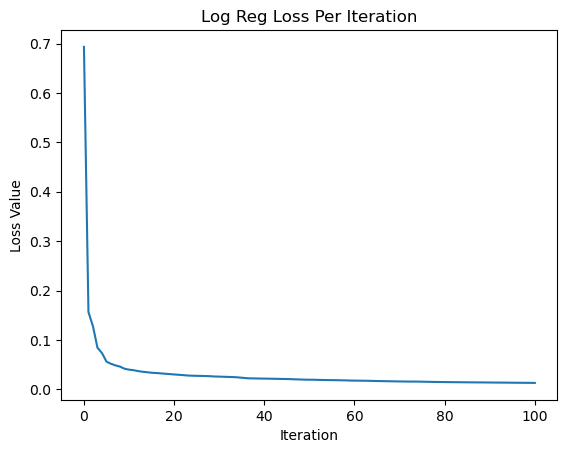

In [18]:
from pyspark.ml.classification import LogisticRegressionTrainingSummary
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
import matplotlib.pyplot as plt

log_reg_acc = np.array([log_reg.summary.objectiveHistory])
plt.plot(log_reg_acc.flatten())
plt.title("Log Reg Loss Per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss Value")
plt.savefig('./Log_Reg_Loss_Per_Iteration.png')
plt.show()

In [19]:
# Training the model with the training data and storing the predictions in a variable
LR_train_results = log_reg.evaluate(training_df).predictions

In [20]:
# Testing the model and storing the predictions to a variable
LR_test_results = log_reg.evaluate(test_df).predictions

In [21]:
# Get validation results
LR_validation_results = log_reg.evaluate(validation_df).predictions

In [22]:
# Get ending time and find model's real runtime
end = datetime.now()
LR_time = end - begin
print(LR_time)

0:00:13.484821


## Random Forest ML Model

In [23]:
from pyspark.ml.classification import RandomForestClassifier

In [24]:
# Get beginning runtime point
begining = datetime.now()

# Make the random forest model and fit with training data
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_feature_vector", numTrees=12, featureSubsetStrategy='sqrt').fit(training_df)

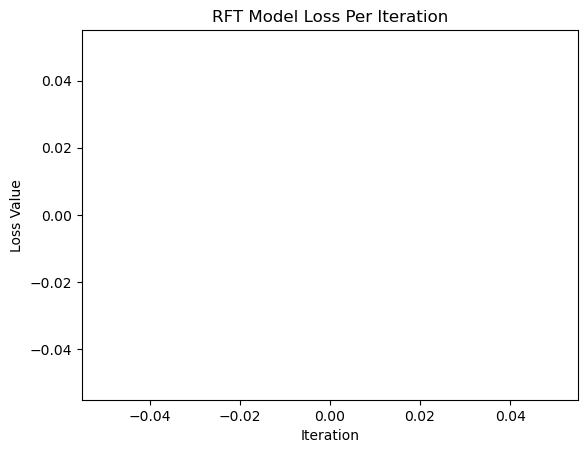

In [25]:
rf_acc = np.array([rf.summary.objectiveHistory])
plt.plot(rf_acc.flatten())
plt.title("RFT Model Loss Per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss Value")
plt.savefig('./RFT_Loss_Per_Iteration.png')
plt.show()

In [26]:
# Training the model with the training data and storing the predictions in a variable
RF_train_results = log_reg.evaluate(training_df).predictions

In [27]:
# Get the test data results
RF_test_results = rf.evaluate(test_df).predictions

In [28]:
# Get the validation data results
RF_validation_results = rf.evaluate(validation_df).predictions

In [29]:
# Get ending time and find model's real runtime
end = datetime.now()

RF_time = end - begin
print(RF_time)

0:00:19.232368


## Support Vector Classifier ML Model

In [30]:
from pyspark.ml.classification import LinearSVC

In [31]:
# Get beginning runtime point
begin = datetime.now()

In [32]:
#make the model
svc = LinearSVC(featuresCol="scaled_feature_vector",labelCol="label",predictionCol="prediction",rawPredictionCol="rawPrediction").fit(training_df)
print(svc)

LinearSVCModel: uid=LinearSVC_d47f1149e29e, numClasses=2, numFeatures=140


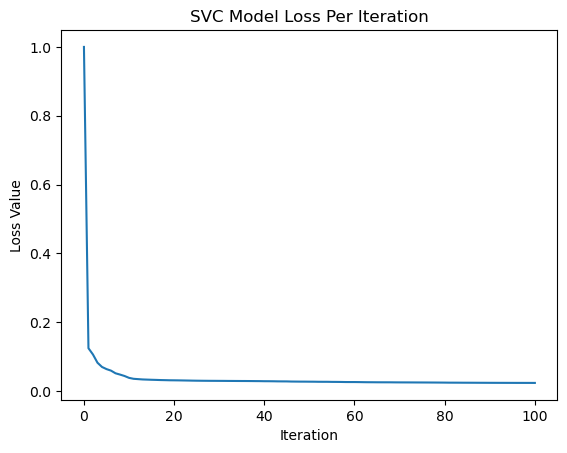

In [33]:
svc_acc = np.array([svc.summary().objectiveHistory])
plt.plot(svc_acc.flatten())
plt.title("SVC Model Loss Per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss Value")
plt.savefig('./SVC_Loss_Per_Iteration.png')
plt.show()

In [34]:
# Training the model with the training data and storing the predictions in a variable
SVC_train_results = svc.evaluate(training_df).predictions

In [35]:
# Get the validation data results
SVC_test_results = svc.evaluate(test_df).predictions

In [36]:
# Get the validation data results
SVC_validation_results = svc.evaluate(validation_df).predictions

In [37]:
# Get ending time and find model's real runtime
end = datetime.now()

SVC_time = end - begin
print(SVC_time)

0:00:09.957646


In [38]:
# Total training time calculation
total_time = end - begining
# time_list.append(total_time.total_seconds())
# time_writer_obj.writerow(time_list)
# time_file.close()
print(total_time)

0:00:15.703475


## Confusion Matrix

In [39]:
#The confusion matrix is reserved for binary classifiers, measuring overall accuracy and accuracy of each classification label.
#This is done by finding true positive, false positive, true negative, and false negative comparing the label with prediction
def confusion_matrix(test_results, model_name):
    
    #labels and predictions match
    tp = test_results[(test_results.label==1) & (test_results.prediction==1)].count()
    tn = test_results[(test_results.label==0) & (test_results.prediction==0)].count()
    #labels and predictions don't match
    fp = test_results[(test_results.label==0) & (test_results.prediction==1)].count()
    fn = test_results[(test_results.label==1) & (test_results.prediction==0)].count()

    #overall accuracy
    accuracy = ((tp+tn) / test_results.count()) * 100
    #Sensitivity/recall/true positive rate
    recall = (tn / (tp + tn)) * 100
    #Specificity/true negative rate
    specificity = (tn / (tn + fp)) * 100
    #precision/positive predictive value
    precision = (tp / (tp + fp)) * 100
    #negative predictive value
    neg_pred_val = (tn / (tn + fn)) * 100

    import matplotlib.pyplot as plt
    import numpy
    from sklearn import metrics
    
    confusion_matrix = numpy.array([[tp, fp], [fn, tn]])
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Positive', 'Negative'])
    cm_display.plot()
    plt.title(model_name)
    plt.savefig('./' + model_name +'.png')
    plt.show()

    results = {
        "accuracy": accuracy,
        "recall": recall,
        "specificity": specificity,
        "precision": precision,
        "neg_pred_val": neg_pred_val
    }

    return results

## Results Calculation

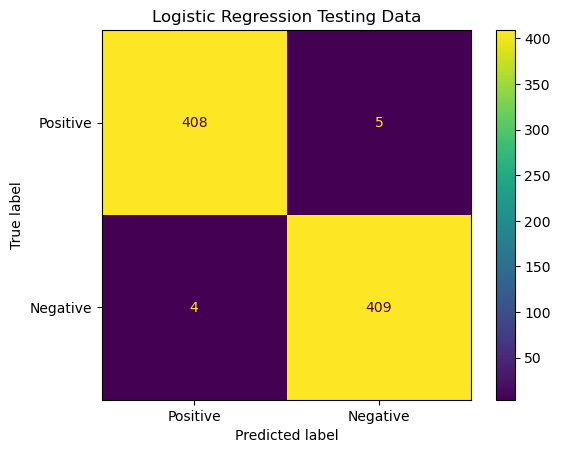

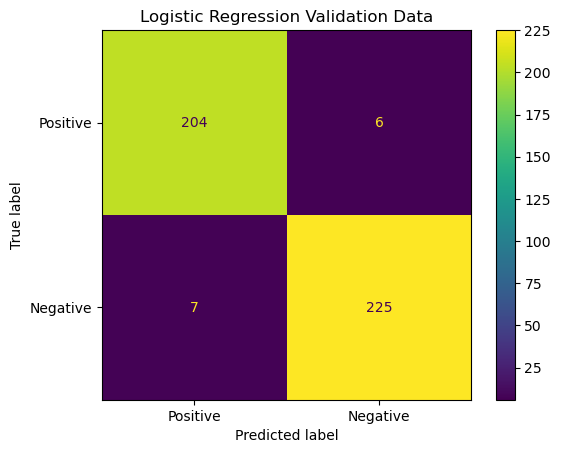

Logistic Regression Test Results on ECG Data:
Overall Accuracy: 98.9104%
Recall (True Positive Rate): 50.0612%
Specificity (True Negative Rate): 98.7923%
Precision (Positive Prediction Value): 98.7893%
Negative Prediction Value: 99.0315%

Logistic Regression Validation Results on ECG Data:
Overall Accuracy: 97.0588%
Recall (True Positive Rate): 52.4476%
Specificity (True Negative Rate): 97.4026%
Precision (Positive Prediction Value): 97.1429%
Negative Prediction Value: 96.9828%



In [40]:
LR_test_metrics = confusion_matrix(LR_test_results, 'Logistic Regression Testing Data')
LR_validation_metrics = confusion_matrix(LR_validation_results, 'Logistic Regression Validation Data')

print("Logistic Regression Test Results on ECG Data:")
print("Overall Accuracy: {a:2.4f}%".format(a = LR_test_metrics["accuracy"]))
print("Recall (True Positive Rate): {a:2.4f}%".format(a = LR_test_metrics["recall"]))
print("Specificity (True Negative Rate): {a:2.4f}%".format(a = LR_test_metrics["specificity"]))
print("Precision (Positive Prediction Value): {a:2.4f}%".format(a = LR_test_metrics["precision"]))
print("Negative Prediction Value: {a:2.4f}%".format(a = LR_test_metrics["neg_pred_val"]))
print()
print("Logistic Regression Validation Results on ECG Data:")
print("Overall Accuracy: {a:2.4f}%".format(a = LR_validation_metrics["accuracy"]))
print("Recall (True Positive Rate): {a:2.4f}%".format(a = LR_validation_metrics["recall"]))
print("Specificity (True Negative Rate): {a:2.4f}%".format(a = LR_validation_metrics["specificity"]))
print("Precision (Positive Prediction Value): {a:2.4f}%".format(a = LR_validation_metrics["precision"]))
print("Negative Prediction Value: {a:2.4f}%".format(a = LR_validation_metrics["neg_pred_val"]))
print()

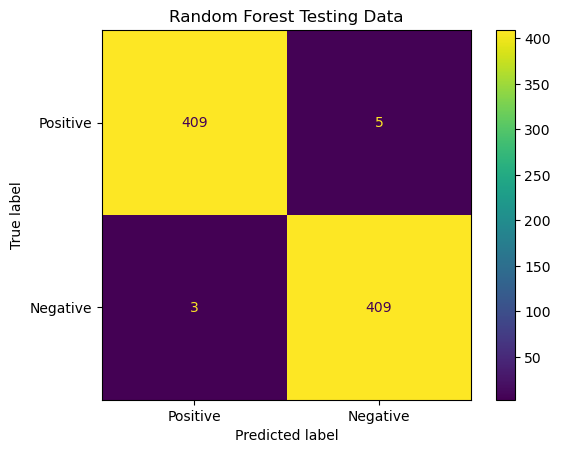

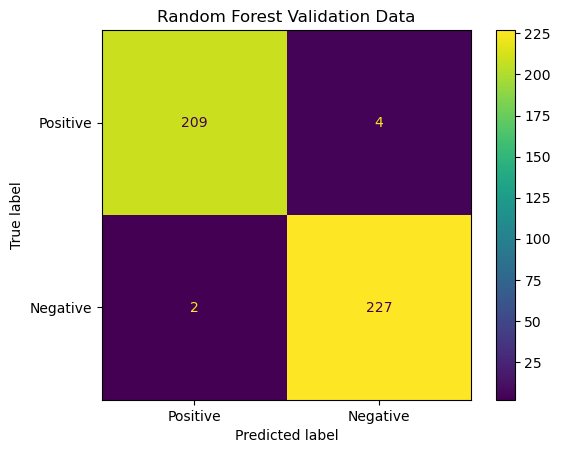

Random Forest Test Results on ECG Data:
Overall Accuracy: 99.0315%
Recall (True Positive Rate): 50.0000%
Specificity (True Negative Rate): 98.7923%
Precision (Positive Prediction Value): 98.7923%
Negative Prediction Value: 99.2718%

Random Forest Validation Results on ECG Data:
Overall Accuracy: 98.6425%
Recall (True Positive Rate): 52.0642%
Specificity (True Negative Rate): 98.2684%
Precision (Positive Prediction Value): 98.1221%
Negative Prediction Value: 99.1266%



In [41]:
RF_test_metrics = confusion_matrix(RF_test_results, "Random Forest Testing Data")
RF_validation_metrics = confusion_matrix(RF_validation_results, "Random Forest Validation Data")

print("Random Forest Test Results on ECG Data:")
print("Overall Accuracy: {a:2.4f}%".format(a = RF_test_metrics["accuracy"]))
print("Recall (True Positive Rate): {a:2.4f}%".format(a = RF_test_metrics["recall"]))
print("Specificity (True Negative Rate): {a:2.4f}%".format(a = RF_test_metrics["specificity"]))
print("Precision (Positive Prediction Value): {a:2.4f}%".format(a = RF_test_metrics["precision"]))
print("Negative Prediction Value: {a:2.4f}%".format(a = RF_test_metrics["neg_pred_val"]))
print()
print("Random Forest Validation Results on ECG Data:")
print("Overall Accuracy: {a:2.4f}%".format(a = RF_validation_metrics["accuracy"]))
print("Recall (True Positive Rate): {a:2.4f}%".format(a = RF_validation_metrics["recall"]))
print("Specificity (True Negative Rate): {a:2.4f}%".format(a = RF_validation_metrics["specificity"]))
print("Precision (Positive Prediction Value): {a:2.4f}%".format(a = RF_validation_metrics["precision"]))
print("Negative Prediction Value: {a:2.4f}%".format(a = RF_validation_metrics["neg_pred_val"]))
print()

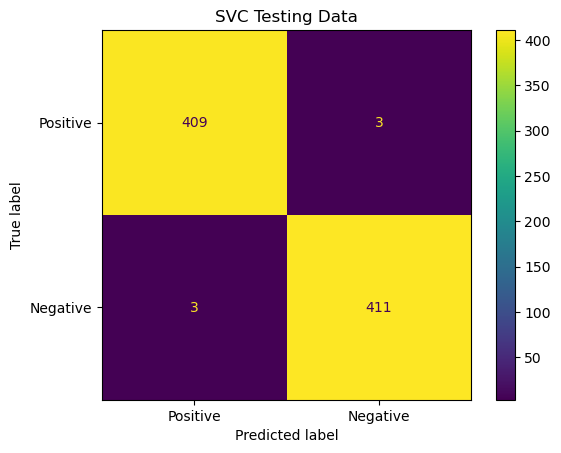

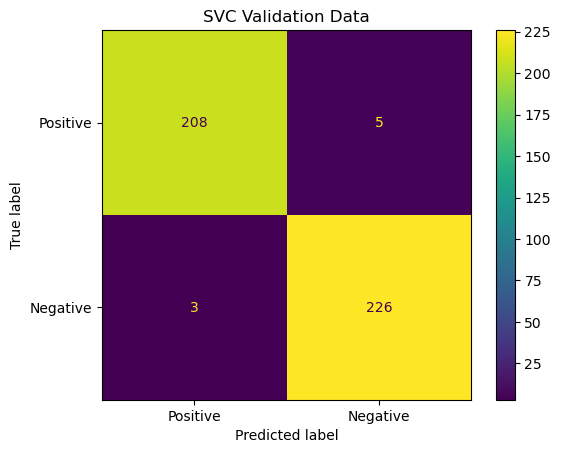

Support Vector Classifier Test Results on ECG Data:
Overall Accuracy: 99.2736%
Recall (True Positive Rate): 50.1220%
Specificity (True Negative Rate): 99.2754%
Precision (Positive Prediction Value): 99.2718%
Negative Prediction Value: 99.2754%

Support Vector Classifier Validation Results on ECG Data:
Overall Accuracy: 98.1900%
Recall (True Positive Rate): 52.0737%
Specificity (True Negative Rate): 97.8355%
Precision (Positive Prediction Value): 97.6526%
Negative Prediction Value: 98.6900%



In [43]:
SVC_test_metrics = confusion_matrix(SVC_test_results, "SVC Testing Data")
SVC_validation_metrics = confusion_matrix(SVC_validation_results, "SVC Validation Data")

print("Support Vector Classifier Test Results on ECG Data:")
print("Overall Accuracy: {a:2.4f}%".format(a = SVC_test_metrics["accuracy"]))
print("Recall (True Positive Rate): {a:2.4f}%".format(a = SVC_test_metrics["recall"]))
print("Specificity (True Negative Rate): {a:2.4f}%".format(a = SVC_test_metrics["specificity"]))
print("Precision (Positive Prediction Value): {a:2.4f}%".format(a = SVC_test_metrics["precision"]))
print("Negative Prediction Value: {a:2.4f}%".format(a = SVC_test_metrics["neg_pred_val"]))
print()
print("Support Vector Classifier Validation Results on ECG Data:")
print("Overall Accuracy: {a:2.4f}%".format(a = SVC_validation_metrics["accuracy"]))
print("Recall (True Positive Rate): {a:2.4f}%".format(a = SVC_validation_metrics["recall"]))
print("Specificity (True Negative Rate): {a:2.4f}%".format(a = SVC_validation_metrics["specificity"]))
print("Precision (Positive Prediction Value): {a:2.4f}%".format(a = SVC_validation_metrics["precision"]))
print("Negative Prediction Value: {a:2.4f}%".format(a = SVC_validation_metrics["neg_pred_val"]))
print()

## Results Output

In [ ]:
#with statement guarantees all data is written out to file and file object is closed properly
# with open('results-serial.txt', 'w', encoding="utf-8") as f:
#     f.write("Logistic Regression Runtime: " + str(LR_time) + '\n')
#     f.write("Logistic Regression Test Results:" + '\n')
#     f.write("Overall Accuracy: " + str(LR_test_metrics["accuracy"]) + '\n')
#     f.write("Recall: " + str(LR_test_metrics["recall"]) + '\n')
#     f.write("Specificity: " + str(LR_test_metrics["specificity"]) + '\n')
#     f.write("Precision: " + str(LR_test_metrics["precision"]) + '\n')
#     f.write("Negative Prediction Value: " + str(LR_test_metrics["neg_pred_val"]) + '\n')
#     f.write('\n')
#     f.write("Logistic Regression Validation Results:" + '\n')
#     f.write("Overall Accuracy: " + str(LR_validation_metrics["accuracy"]) + '\n')
#     f.write("Recall: " + str(LR_validation_metrics["recall"]) + '\n')
#     f.write("Specificity: " + str(LR_validation_metrics["specificity"]) + '\n')
#     f.write("Precision: " + str(LR_validation_metrics["precision"]) + '\n')
#     f.write("Negative Prediction Value: " + str(LR_validation_metrics["neg_pred_val"]) + '\n')
#     f.write('\n')
    
#     f.write("Random Forest Runtime: " + str(RF_time) + '\n')
#     f.write("Random Forest Test Results:" + '\n')
#     f.write("Overall Accuracy: " + str(RF_test_metrics["accuracy"]) + '\n')
#     f.write("Recall: " + str(RF_test_metrics["recall"]) + '\n')
#     f.write("Specificity: " + str(RF_test_metrics["specificity"]) + '\n')
#     f.write("Precision: " + str(RF_test_metrics["precision"]) + '\n')
#     f.write("Negative Prediction Value: " + str(RF_test_metrics["neg_pred_val"]) + '\n')
#     f.write('\n')
#     f.write("Random Forest Validation Results:" + '\n')
#     f.write("Overall Accuracy: " + str(RF_validation_metrics["accuracy"]) + '\n')
#     f.write("Recall: " + str(RF_validation_metrics["recall"]) + '\n')
#     f.write("Specificity: " + str(RF_validation_metrics["specificity"]) + '\n')
#     f.write("Precision: " + str(RF_validation_metrics["precision"]) + '\n')
#     f.write("Negative Prediction Value: " + str(RF_validation_metrics["neg_pred_val"]) + '\n')
#     f.write('\n')
    
#     f.write("Support Vector Classifier Runtime: " + str(SVC_time) + '\n')
#     f.write("Support Vector Classifier Test Results:" + '\n')
#     f.write("Overall Accuracy: " + str(SVC_test_metrics["accuracy"]) + '\n')
#     f.write("Recall: " + str(SVC_test_metrics["recall"]) + '\n')
#     f.write("Specificity: " + str(SVC_test_metrics["specificity"]) + '\n')
#     f.write("Precision: " + str(SVC_test_metrics["precision"]) + '\n')
#     f.write("Negative Prediction Value: " + str(SVC_test_metrics["neg_pred_val"]) + '\n')
#     f.write('\n')
#     f.write("Support Vector Classifier Validation Results:" + '\n')
#     f.write("Overall Accuracy: " + str(SVC_validation_metrics["accuracy"]) + '\n')
#     f.write("Recall: " + str(SVC_validation_metrics["recall"]) + '\n')
#     f.write("Specificity: " + str(SVC_validation_metrics["specificity"]) + '\n')
#     f.write("Precision: " + str(SVC_validation_metrics["precision"]) + '\n')
#     f.write("Negative Prediction Value: " + str(SVC_validation_metrics["neg_pred_val"]) + '\n')
#     f.write('\n')

In [ ]:
# # Reading results into csv
# with open('results-serial.txt', 'r') as f:
#   reader = csv.reader(f)
#   with open('Parallel_Processing_Concepts_Serial.csv', 'a', newline='') as w:
#     writer = csv.writer(w)
#     writer.writerow('\n')
#     writer.writerows(reader)

In [53]:
# time_file = open('Parallel_Processing_Conecpts_Serial_Time.csv','a')
# time_reader = csv.reader(time_file)
# time_writer_obj = writer(time_file)
# time_list.append(total_time.total_seconds())
# time_writer_obj.writerow(time_list)

101

In [39]:
#close the spark session
spark.stop()